In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, LSTM, Embedding
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import mean_squared_error

In [2]:
rnafold = pd.read_csv('datasets/rnacofold.csv')
rnafold['sequence'] = rnafold['crRNA'] + rnafold['tracrRNA']

In [3]:
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]
rnafold['words'] = rnafold.apply(lambda x: getKmers(x['sequence']), axis=1)
texts = list(rnafold['words'])
for item in range(len(texts)):
    texts[item] = ' '.join(texts[item])

In [14]:
cv = CountVectorizer()
X = cv.fit_transform(texts).toarray()
y = rnafold['fluo_8h']
num_classes = 3
yc = pd.qcut(y, num_classes, labels=False)
yh = to_categorical(yc)

### Classification

#### Multi-layer Perceptrons

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, yh, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72, 256) (18, 256) (72, 3) (18, 3)


In [122]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_64 (Dense)             (None, 3)                 303       
Total params: 26,003
Trainable params: 26,003
Non-trainable params: 0
_________________________________________________________________


In [123]:
history = model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
1/1 [==============================] - 0s 429ms/step - loss: 0.7113 - accuracy: 0.3472
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.6836 - accuracy: 0.3889
Epoch 3/5
1/1 [==============================] - 0s 13ms/step - loss: 0.6576 - accuracy: 0.4306
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.6334 - accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 0.6109 - accuracy: 0.5556


In [124]:
_, acc = model.evaluate(X_test, y_test, verbose=1)
print("accuracy = " + str(acc))

1/1 [==============================] - 0s 153ms/step - loss: 0.6817 - accuracy: 0.2222
accuracy = 0.2222222238779068


#### CNN

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72, 256, 1) (18, 256, 1) (72, 1) (18, 1)


In [84]:
verbose, epochs, batch_size = 0, 5, 100
n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 254, 64)           256       
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 252, 64)           12352     
_________________________________________________________________
dropout_14 (Dropout)         (None, 252, 64)           0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 126, 64)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 8064)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               806500    
_________________________________________________________________
dense_36 (Dense)             (None, 1)               

In [85]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
accuracy

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 0.4167
Epoch 2/5
1/1 [==============================] - 0s 96ms/step - loss: 0.0000e+00 - accuracy: 0.4583
Epoch 3/5
1/1 [==============================] - 0s 89ms/step - loss: 0.0000e+00 - accuracy: 0.5139
Epoch 4/5
1/1 [==============================] - 0s 115ms/step - loss: 0.0000e+00 - accuracy: 0.5417
Epoch 5/5
1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - accuracy: 0.5417


0.3888888955116272

#### RNN

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72, 256, 1) (18, 256, 1) (72, 1) (18, 1)


In [111]:
model = Sequential()
'''
top_words = 5000
max_review_length = 500
embedding_vecor_length = 32
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
'''
model.add(LSTM(64, input_shape=(n_timesteps, n_features)))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
#model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
#model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_57 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [112]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
accuracy

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.0000e+00 - accuracy: 0.3194
Epoch 2/5
1/1 [==============================] - 0s 182ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 3/5
1/1 [==============================] - 0s 175ms/step - loss: 0.0000e+00 - accuracy: 0.2917
Epoch 4/5
1/1 [==============================] - 0s 181ms/step - loss: 0.0000e+00 - accuracy: 0.3472
Epoch 5/5
1/1 [==============================] - 0s 190ms/step - loss: 0.0000e+00 - accuracy: 0.3472


0.2777777910232544

### Regression

#### CNN

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72, 256, 1) (18, 256, 1) (72, 1) (18, 1)


In [160]:
verbose, epochs, batch_size = 0, 5, 100
n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, 254, 64)           256       
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 252, 64)           12352     
_________________________________________________________________
dropout_19 (Dropout)         (None, 252, 64)           0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 126, 64)           0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 8064)              0         
_________________________________________________________________
dense_73 (Dense)             (None, 100)               806500    
_________________________________________________________________
dense_74 (Dense)             (None, 1)               

In [168]:
model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1)
y_pred = model.predict(X_test)

Epoch 1/100
15/15 [==============================] - 0s 14ms/step - loss: 26395748.0000
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - loss: 24539272.0000
Epoch 3/100
15/15 [==============================] - 0s 17ms/step - loss: 30086148.0000
Epoch 4/100
15/15 [==============================] - 0s 14ms/step - loss: 24952028.0000
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 29612358.0000
Epoch 6/100
15/15 [==============================] - 0s 13ms/step - loss: 25851140.0000
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 24617916.0000
Epoch 8/100
15/15 [==============================] - 0s 13ms/step - loss: 31454926.0000
Epoch 9/100
15/15 [==============================] - 0s 14ms/step - loss: 22609302.0000
Epoch 10/100
15/15 [==============================] - 0s 14ms/step - loss: 26409182.0000
Epoch 11/100
15/15 [==============================] - 0s 15ms/step - loss: 27161328.0000
Epoch 12/100
15/15 [==========

15/15 [==============================] - 0s 16ms/step - loss: 22237116.0000
Epoch 93/100
15/15 [==============================] - 0s 16ms/step - loss: 14113520.0000
Epoch 94/100
15/15 [==============================] - 0s 21ms/step - loss: 18312652.0000
Epoch 95/100
15/15 [==============================] - 0s 16ms/step - loss: 16534135.0000
Epoch 96/100
15/15 [==============================] - 0s 15ms/step - loss: 18133484.0000
Epoch 97/100
15/15 [==============================] - 0s 13ms/step - loss: 21374406.0000
Epoch 98/100
15/15 [==============================] - 0s 15ms/step - loss: 23483236.0000
Epoch 99/100
15/15 [==============================] - 0s 13ms/step - loss: 21607850.0000
Epoch 100/100
15/15 [==============================] - 0s 13ms/step - loss: 17455040.0000


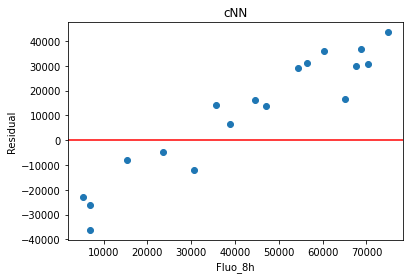

In [163]:
plt.scatter(y_test, (y_test - y_pred))
plt.axhline(y=0, color='r', linestyle='-')
plt.title('cNN')
#plt.xticks(rotation=90)
plt.xlabel('Fluo_8h')
plt.ylabel('Residual')
plt.show()

#### RNN

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72, 256, 1) (18, 256, 1) (72, 1) (18, 1)


In [186]:
model = Sequential()
model.add(LSTM(64, input_shape=(n_timesteps, n_features)))
model.add(Dense(64, activation="relu"))
model.add(Dense(n_outputs))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_79 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [187]:
model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1)
y_pred = model.predict(X_test)

Epoch 1/100
15/15 [==============================] - 4s 101ms/step - loss: 2462938624.0000
Epoch 2/100
15/15 [==============================] - 1s 92ms/step - loss: 2462532608.0000
Epoch 3/100
15/15 [==============================] - 1s 94ms/step - loss: 2461834240.0000
Epoch 4/100
15/15 [==============================] - 1s 91ms/step - loss: 2460964096.0000
Epoch 5/100
15/15 [==============================] - 1s 95ms/step - loss: 2459986944.0000
Epoch 6/100
15/15 [==============================] - 2s 102ms/step - loss: 2458915328.0000
Epoch 7/100
15/15 [==============================] - 2s 103ms/step - loss: 2457739520.0000
Epoch 8/100
15/15 [==============================] - 1s 98ms/step - loss: 2456393216.0000
Epoch 9/100
15/15 [==============================] - 2s 99ms/step - loss: 2454967808.0000
Epoch 10/100
15/15 [==============================] - 1s 95ms/step - loss: 2453324800.0000
Epoch 11/100
15/15 [==============================] - 1s 97ms/step - loss: 2451613952.0000
Epoch

15/15 [==============================] - 2s 158ms/step - loss: 1928252032.0000
Epoch 91/100
15/15 [==============================] - 2s 154ms/step - loss: 1918283776.0000
Epoch 92/100
15/15 [==============================] - 2s 150ms/step - loss: 1908298880.0000
Epoch 93/100
15/15 [==============================] - 2s 129ms/step - loss: 1898326528.0000
Epoch 94/100
15/15 [==============================] - 2s 138ms/step - loss: 1888335104.0000
Epoch 95/100
15/15 [==============================] - 2s 144ms/step - loss: 1878104704.0000
Epoch 96/100
15/15 [==============================] - 2s 156ms/step - loss: 1867824896.0000
Epoch 97/100
15/15 [==============================] - 2s 128ms/step - loss: 1857760384.0000
Epoch 98/100
15/15 [==============================] - 2s 156ms/step - loss: 1847330688.0000
Epoch 99/100
15/15 [==============================] - 2s 151ms/step - loss: 1837269376.0000
Epoch 100/100
15/15 [==============================] - 2s 132ms/step - loss: 1827238528.0000


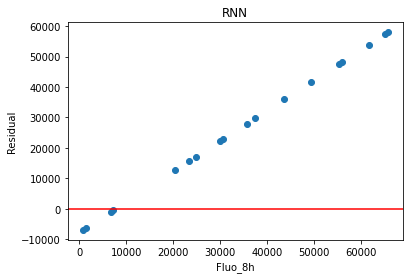

In [190]:
plt.scatter(y_test, (y_test - y_pred))
plt.axhline(y=0, color='r', linestyle='-')
plt.title('RNN')
#plt.xticks(rotation=90)
plt.xlabel('Fluo_8h')
plt.ylabel('Residual')
plt.show()

### Dataprep

In [ ]:
with open('datasets/output.out', 'r') as reader:
    #print(reader.read())
    output = list(reader)

In [ ]:
output = [i.strip() for i in output]
output = [output[i:i+7] for i in range(0, len(output), 7)]
output

In [ ]:
df = pd.DataFrame(output)
df[7] = df[1].str[:-9]
df[1] = df[1].str[-6:-1]
df[2] = df[2].str[-6:-1]
df[3] = df[3].str.replace('frequency of mfe structure in ensemble', '')
df[8] = df[3].apply(lambda x: x.split(';')[0])
df[9] = df[3].apply(lambda x: x.split('=')[1])
df[10] = df[0].apply(lambda x: x.split('&')[0])
df[11] = df[0].apply(lambda x: x.split('&')[1])
numbers = pd.Series(np.arange(len(df))+1).astype(str)
df[12] = 'c' + numbers
df[13] = 't' + numbers
df = df[[12, 10, 13, 11, 7, 1, 2, 8, 9]]
df[[1, 2, 8, 9]] = df[[1, 2, 8, 9]].astype(float)
df[8] = df[8] * 100
df = df.rename(columns={12: 'c_index', 10: 'crRNA', 13: 't_index',
                        11: 'tracrRNA', 7: 'MFE_structures', 1: 'MFE',
                       2: 'free_energy_thermodynamic_ensemble',
                       8: 'frequency_MFR_structures', 9: 'delta_G'})

df

In [ ]:
df.to_csv('datasets/rnacofold.csv', index=False)

### New Dataprep

In [ ]:
with open('datasets/new_seq.out', 'r') as reader:
    #print(reader.read())
    output = list(reader)

In [ ]:
output = [i.strip() for i in output]
output = [output[i:i+5] for i in range(0, len(output), 5)]
output

In [ ]:
df = pd.DataFrame(output)
df[11] = df[1].apply(lambda x: (x.split(' ( ')[0]))
df[1] = df[1].apply(lambda x: (x.split(' ( ')[1]).split(')')[0])
df[2] = df[2].apply(lambda x: (x.split(' [ ')[1]).split(']')[0])
df[31] = df[3].apply(lambda x: ((x.split(' { ')[1]).split(' d=')[1]).split('}')[0])
df[32] = df[3].apply(lambda x: (x.split(' { ')[0]))
df[3] = df[3].apply(lambda x: (x.split(' { ')[1]).split(' d=')[0])
df[41] = df[4].apply(lambda x: (x.split(';')[1]).split(' ')[-1])
df[4] = df[4].apply(lambda x: (x.split(';')[0]).split(' ')[-1])
#df[2] = df[1].str[-6:-1]
df

In [ ]:
df = df[[0, 11, 1, 2, 32, 3, 31, 4, 41]]
df = df.rename(columns={0: 'sequence', 11: 'optimal_secondary_structure', 1: 'optimal_mfe',
                       2: 'free_energy_thermo_ensemble', 32: 'centroid_secondary_structure',
                       3: 'centroid_mfe', 31: 'd', 4: 'freq_mfe_structure_in_ensemble', 41: 'ensemble_diversity'})
df

In [ ]:
df.to_csv('datasets/new_seq.csv', index=False)